<a href="https://colab.research.google.com/github/Nobel712/GAN/blob/main/Pix2Pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout,Input
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from zipfile import ZipFile

with ZipFile('/content/drive/MyDrive/Deep_Db/maps.zip','r') as zip:
  zip.extractall('/content')

In [4]:
from os import listdir
from numpy import asarray,load
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from matplotlib import  pyplot
import numpy as np

In [5]:
def load_images(path, size=(256,512)):
  src_list, tar_list=list(), list()
  for filename in listdir(path):
    pixels=load_img(path+ filename, target_size=size)
    pixels=img_to_array(pixels)
    sat_img, map_img=pixels[:,:256], pixels[:, 256:]
    src_list.append(sat_img)
    tar_list.append(map_img)
  return [asarray(src_list), asarray(tar_list)]

path='/content/maps/train/'
[src_images, tar_images]=load_images(path)
print('loaded: ', src_images.shape, tar_images.shape )


loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


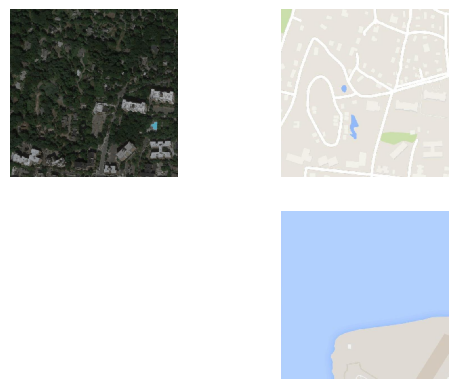

In [6]:
import matplotlib.pyplot as plt
n_samples=2
for i in range(n_samples):
  plt.subplot(2,n_samples, 1+i)
  plt.axis('off')
  plt.imshow(src_images[i].astype('uint8'))

for i in range(n_samples):
  plt.subplot(2, n_samples, i+ n_samples+ i)
  plt.axis('off')
  plt.imshow(tar_images[i].astype('uint8'))
plt.show()

In [7]:
def define_discriminator(image_shape):


	init = RandomNormal(stddev=0.02)
	in_src_image = Input(shape=image_shape)
	in_target_image = Input(shape=image_shape)


	merged = Concatenate()([in_src_image, in_target_image])


	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)

	model = Model([in_src_image, in_target_image], patch_out)

	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [8]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
  init=RandomNormal(stddev=0.02)
  g=Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
  if batchnorm:
    g=BatchNormalization()(g,training=True)
  g=LeakyReLU(alpha=0.2)(g)
  return g

In [9]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
  init=RandomNormal(stddev=0.02)
  g=Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
  g=BatchNormalization()(g, training=True)
  if dropout:
    g=Dropout(0.5)(g, training=True)
  g=Concatenate()([g,skip_in])
  g=Activation('relu')(g)
  return g

In [10]:
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: CD512-CD512-CD512-C512-C256-C128-C64
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) #Modified
	out_image = Activation('tanh')(g)  #Generates images in the range -1 to 1. So change inputs also to -1 to 1
	# define model
	model = Model(in_image, out_image)
	return model


In [11]:
def define_gen(g_model, d_model, image_shape):
  for layer in d_model.layers:
    if not isinstance(layer, BatchNormalization):
      layer.trainable=False


  in_src=Input(shape=image_shape)
  gen_out=g_model(in_src)
  dis_out=d_model([in_src, gen_out])
  model=Model(in_src, [dis_out, gen_out])
  opt=Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss=['binary_crossentropy','mae'],optimizer=opt, loss_weights=[1,100])
  return model

In [12]:
def generate_real_samples(dataset, n_samples, patch_shape):
  trainA, trainB=dataset
  ix=randint(0, trainA.shape[0], n_samples)
  x1,x2=trainA[ix],trainB[ix]
  y=ones((n_samples, patch_shape, patch_shape, 1))
  return [x1,x2],y

In [13]:
def generate_fake_samples(g_model, samples, patch_shape):
	X = g_model.predict(samples)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [14]:
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [15]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

In [16]:
image_shape = src_images.shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gen(g_model, d_model, image_shape)

#Define data
# load and prepare training images
data = [src_images, tar_images]
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
from datetime import datetime
start1 = datetime.now()

train(d_model, g_model, gan_model, dataset, n_epochs=50, n_batch=1)
#Reports parameters for each batch (total 1600) for each epoch.
#For 10 epochs we should see 16000

stop1 = datetime.now()
#Execution time of the model
execution_time = stop1-start1
print("Execution time is: ", execution_time)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 20ms/step
>8462, d1[0.219] d2[0.213] g[6.084]
1/1 [==============================] - 0s 24ms/step
>8463, d1[0.138] d2[0.215] g[8.242]
1/1 [==============================] - 0s 21ms/step
>8464, d1[0.120] d2[0.202] g[8.616]
1/1 [==============================] - 0s 25ms/step
>8465, d1[0.125] d2[0.280] g[12.032]
1/1 [==============================] - 0s 27ms/step
>8466, d1[0.687] d2[0.205] g[8.547]
1/1 [==============================] - 0s 25ms/step
>8467, d1[0.549] d2[0.288] g[4.280]
1/1 [==============================] - 0s 20ms/step
>8468, d1[0.149] d2[0.325] g[12.030]
1/1 [==============================] - 0s 22ms/step
>8469, d1[0.448] d2[0.321] g[6.080]
1/1 [==============================] - 0s 24ms/step
>8470, d1[0.088] d2[0.308] g[10.699]
1/1 [==============================] - 0s 24ms/step
>8471, d1[0.088] d2[0.245] g[6.195]
1/1 [==============================] - 0s 20ms/step
>8472, d1[0.10

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>Saved: plot_010960.png and model_010960.h5
1/1 [==============================] - 0s 30ms/step
>10961, d1[0.193] d2[0.251] g[8.259]
1/1 [==============================] - 0s 27ms/step
>10962, d1[0.649] d2[0.211] g[5.635]
1/1 [==============================] - 0s 42ms/step
>10963, d1[0.206] d2[0.513] g[7.784]
1/1 [==============================] - 0s 19ms/step
>10964, d1[0.436] d2[0.280] g[8.737]
1/1 [==============================] - 0s 22ms/step
>10965, d1[0.370] d2[0.349] g[5.313]
1/1 [==============================] - 0s 27ms/step
>10966, d1[0.246] d2[0.352] g[6.817]
1/1 [==============================] - 0s 19ms/step
>10967, d1[0.149] d2[0.308] g[8.319]
1/1 [==============================] - 0s 20ms/step
>10968, d1[0.204] d2[0.268] g[7.073]
1/1 [==============================] - 0s 20ms/step
>10969, d1[0.108] d2[0.246] g[8.986]
1/1 [==============================] - 0s 20ms/step
>10970, d1[0.341] d2[0.405] g[8.433]
1/1 [==============================] - 0s 22ms/step
>10971, d1[0.5

In [ ]:
from keras.models import load_model
from numpy.random import randint
from numpy import vstack

model = load_model('sandstone_50epochs.h5')

# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Input-segm-img', 'Output-Generated', 'Original']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i,:,:,0], cmap='gray')
		# show title
		pyplot.title(titles[i])
	pyplot.show()


In [ ]:
[X1, X2] = dataset
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)

###########################################
test_src_img = cv2.imread("sandstone/test_mask.tif", 1)
test_src_img = cv2.resize(test_src_img, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
test_src_img = (test_src_img - 127.5) / 127.5
test_src_img = np.expand_dims(test_src_img, axis=0)

# generate image from source
gen_test_image = model.predict(test_src_img)

#pyplot.imshow(test_src_img[0, :,:,0], cmap='gray')
pyplot.imshow(gen_test_image[0, :,:,0], cmap='gray')